In [ ]:
# Author: Swapnil Acharya
# Date: 6/28/2021

# Comparision of Deep Learning Algorithms based on Transfer Learning

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.5.0


## Prepare Dataset

In [3]:
# {"username":"hellosomeone","key":"2972477b7742f4e1003abb2dac2d52ca"}

In [4]:
# https://www.kaggle.com/andrewmvd/medical-mnist

In [5]:
import os

os.environ['KAGGLE_USERNAME'] = "hellosomeone" # username from the json file
os.environ['KAGGLE_KEY'] = "2972477b7742f4e1003abb2dac2d52ca" # key from the json file

In [6]:
!kaggle datasets download -d andrewmvd/medical-mnist

 96% 81.0M/84.8M [00:01<00:00, 35.5MB/s]
100% 84.8M/84.8M [00:01<00:00, 60.6MB/s]


In [7]:
!ls

medical-mnist.zip  sample_data


In [8]:
mkdir medical_mnist

In [9]:
!ls

medical_mnist  medical-mnist.zip  sample_data


In [10]:
!unzip -q medical-mnist.zip -d medical_mnist/

In [11]:
!ls

medical_mnist  medical-mnist.zip  sample_data


In [12]:
!ls medical_mnist

AbdomenCT  BreastMRI  ChestCT  CXR  Hand  HeadCT


## Create Train and Valid dataset

In [13]:
data_dir = "medical_mnist/"

BATCH_SIZE = 32
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_SHAPE = (IMAGE_HEIGHT,IMAGE_WIDTH,3)

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                              labels="inferred",
                                                              label_mode="int",
                                                              batch_size=BATCH_SIZE,
                                                              image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                              shuffle=True,
                                                              seed=1,
                                                              validation_split=0.2,
                                                              subset="training")

Found 58954 files belonging to 6 classes.
Using 47164 files for training.


In [15]:
class_names = train_ds.class_names
class_names

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

In [16]:
print(f"Num batches in Training Set: {len(train_ds)}")

Num batches in Training Set: 1474


In [17]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                              labels = "inferred",
                                                              label_mode = "int",
                                                              batch_size = BATCH_SIZE,
                                                              image_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
                                                              shuffle = True,
                                                              seed = 1,
                                                              validation_split = 0.2,
                                                              subset="validation")

Found 58954 files belonging to 6 classes.
Using 11790 files for validation.


In [18]:
print(f"Num batches in Validation Set: {len(valid_ds)}")

Num batches in Validation Set: 369


## Visualize Data

In [19]:
#get a batch of data from training set
image_batch, label_batch = next(iter(train_ds))

[]

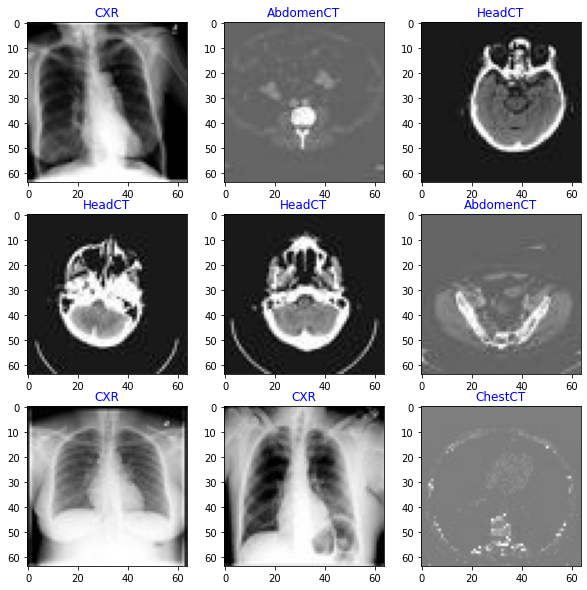

In [20]:
fig, ax = plt.subplots(3,3,figsize=(10,10))

for index, a in enumerate(fig.axes):
    a.imshow(np.array(image_batch[index],np.uint8))
    a.title.set_text(class_names[label_batch[index]])
    a.title.set_color("blue")
plt.plot()

## Create Test Set

So far only Training Set and VLidation Set have been created, a test set can be created by taking a batch from validation set.
It is important to make sure that validation and test set are from the same ditribution.

In [21]:
#get a set of batchs

val_batches = tf.data.experimental.cardinality(valid_ds)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=369>

In [22]:
#get 20% of data from validation set to train set
test_ds = valid_ds.take(val_batches// 5)

In [23]:
#set the remaing 80% as validaion set
valid_ds = valid_ds.skip(val_batches//5)

In [24]:
print(f"Number of Validation Batches: {len(valid_ds)}")

Number of Validation Batches: 296


In [25]:
print(f"Number of Testing Batches: {len(test_ds)}")

Number of Testing Batches: 73


## Configure dataset for Performance

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [27]:
# vgg 19
# Inception -v3
# Resnet 50
# inceptipn resent v2
# mobilenet v2
# efficient 

## VGG - 19

### Download Base Model

In [85]:
### Download Base Model
base_model_vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False,
                                                     weights="imagenet",
                                                     input_shape=None)

80142336/80134624 [==============================] - 1s 0us/step


<p><h4> From Tensorflow website VGG 19 expexts certain kind of inputs. Its own preprocess input must be used whihc will convert the input images from RGB to BGR, them zero-center each color channel with respect to the imageNet dataset, without scaling. In our case, since images are greyscale it probably wont  matter much</h4> </p>

### Get Model's Preprocessing Function

In [86]:
vgg19_preprocess = tf.keras.applications.vgg19.preprocess_input

### Visualize Outputs of Model's Preprocessing Function

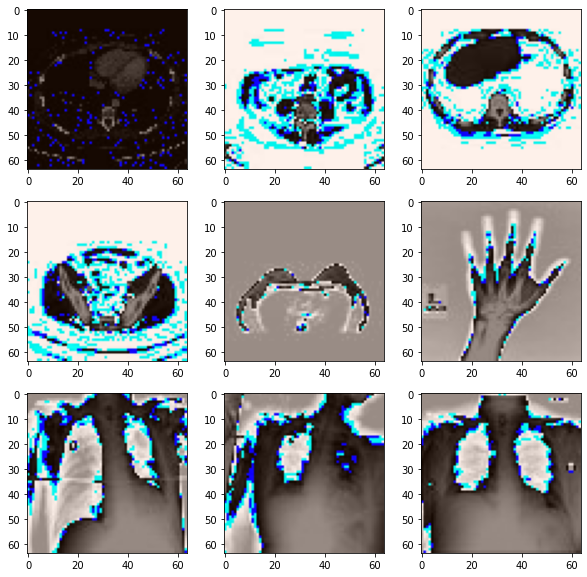

In [87]:
### visuaize the preprocessed input
image_batch, label_batch = next(iter(train_ds))
image_batch = vgg19_preprocess(image_batch)

fig, ax = plt.subplots(3,3,figsize=(10,10))

for index, a in enumerate(fig.axes):
    a.imshow(np.array(image_batch[index],np.uint8))
    
plt.show()

###Freeze Model For Transfer Learning

In [88]:
# In order to use base model as feature extractor, it must be frezzzed and a classifer layer must be added
base_model_vgg19.trainable = False

In [89]:
base_model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

As shown by the outputs of vgg19 summary, clearly the model has been frezzed since the number of trainabel params is 0.

### See output shape of base layer

In [ ]:
#lets see the output shape of base layer
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = vgg19_preprocess(inputs)
outputs = base_model_vgg19(x)
model = tf.keras.Model(inputs,outputs)

In [ ]:
image_batch,labels = next(iter(train_ds))
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 2, 2, 512])

So, the output shape of the base model is shown above, so to generate predictions from block of features over 2x2 spatial locations a global  pooling layer must be used in order to convert it to a single vector. 

### Create Transfer Learning Model

In [ ]:
#create model using functional api
inputs = tf.keras.Input(shape=(IMAGE_SHAPE)) #must use tf.keras.Input for Functional
x = vgg19_preprocess(inputs)
x = base_model_vgg19(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)
model_vgg19 = tf.keras.Model(inputs,outputs)

In [ ]:
#compile model
base_learning_rate = 0.0001
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [ ]:
#view model summary
model_vgg19.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 64, 64, 3)         0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 20,027,462
Trainable params: 3,078
Non-trainable params: 20,024,384
___________________________________________

In [ ]:
#initial accuracy
loss0_vgg19, accuracy0_vgg19 = model_vgg19.evaluate(valid_ds)

296/296 [==============================] - 8s 20ms/step - loss: 14.2783 - accuracy: 0.1648


In [ ]:
print(f"Initial Loss of Vgg19: {loss0_vgg19}")
print(f"Initial Accuracy of Vgg19: {accuracy0_vgg19}")

Initial Loss of Vgg19: 14.278255462646484
Initial Accuracy of Vgg19: 0.16479796171188354


### Train Model

In [ ]:
#train model now
initial_epochs = 5
history_vgg19 = model_vgg19.fit(train_ds,
                         epochs=initial_epochs,
                         validation_data = valid_ds)

Epoch 1/5
1474/1474 [==============================] - 35s 23ms/step - loss: 1.3753 - accuracy: 0.8261 - val_loss: 0.1433 - val_accuracy: 0.9677
Epoch 2/5
1474/1474 [==============================] - 34s 23ms/step - loss: 0.0734 - accuracy: 0.9822 - val_loss: 0.0463 - val_accuracy: 0.9893
Epoch 3/5
1474/1474 [==============================] - 35s 24ms/step - loss: 0.0255 - accuracy: 0.9928 - val_loss: 0.0222 - val_accuracy: 0.9944
Epoch 4/5
1474/1474 [==============================] - 36s 24ms/step - loss: 0.0117 - accuracy: 0.9976 - val_loss: 0.0123 - val_accuracy: 0.9971
Epoch 5/5
1474/1474 [==============================] - 35s 24ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0077 - val_accuracy: 0.9982


### Plot Learning Curves

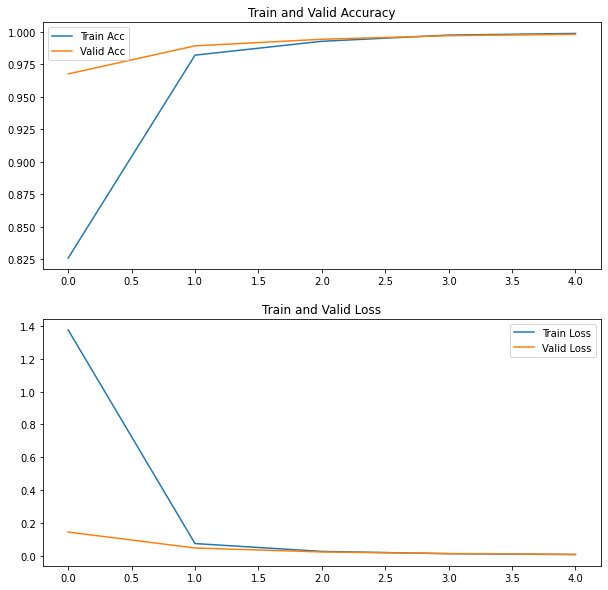

In [ ]:


train_acc = history_vgg19.history['accuracy']
train_loss = history_vgg19.history['loss']

valid_acc = history_vgg19.history['val_accuracy']
valid_loss = history_vgg19.history['val_loss']

fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(train_acc,label="Train Acc")
ax[0].plot(valid_acc,label="Valid Acc")
ax[0].title.set_text("Train and Valid Accuracy")
ax[0].legend(loc="best")

ax[1].plot(train_loss,label="Train Loss")
ax[1].plot(valid_loss,label="Valid Loss")
ax[1].title.set_text("Train and Valid Loss")
ax[1].legend(loc="best")

plt.show()

### Evaluate on Test Set

In [ ]:
# Evaluate on Test Set
acc, loss = model_vgg19.evaluate(test_ds)

73/73 [==============================] - 2s 21ms/step - loss: 0.0076 - accuracy: 0.9983


In [ ]:
print(f"Accuracy on Test Set: {acc}")
print(f"Loss on Test Set: {loss}")

Accuracy on Test Set: 0.007597560063004494
Loss on Test Set: 0.9982876777648926


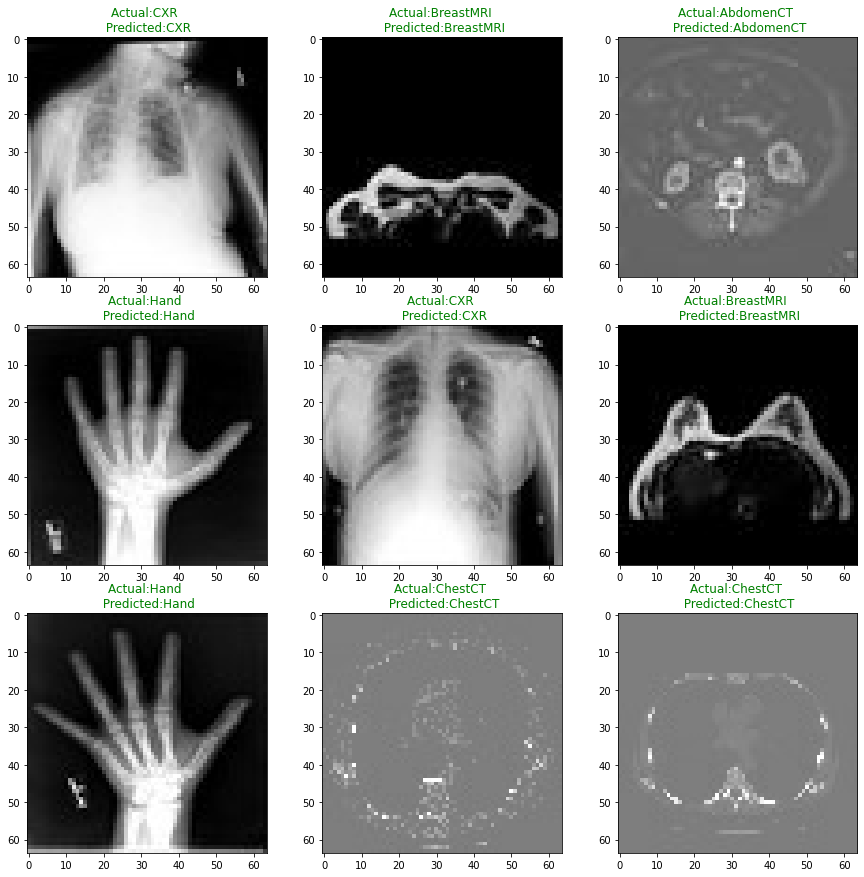

In [ ]:
##Visualize some predictions

image_batch, label_batch = next(iter(test_ds))
predictions = model_vgg19.predict(image_batch) #predict on the recently fetched batch from test set
predictions = np.argmax(predictions,axis=1) #get index of highest probability

fig, ax = plt.subplots(3,3,figsize=(15,15))

for index, a in enumerate(fig.axes):

  a.imshow(np.array(image_batch[index],dtype=np.uint8))
  a.title.set_text(f"Actual:{class_names[label_batch[index]]} \n Predicted:{class_names[predictions[index]]}")
  if predictions[index] == label_batch[index]:
    a.title.set_color("green")
  else:
    a.title.set_color("red")

plt.show()

## Inception - V3

### Download Base Model

In [94]:
# Dowload Base Model
base_model_inceptionv3 = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                                        weights="imagenet",
                                                                        input_shape=None)

### Get Model's Preprocessing

In [95]:
#each model epects it own preprocessing,
inceptionv3_preprocess = tf.keras.applications.inception_v3.preprocess_input

In [96]:
#inception v3 needs at least 75,75 image, so create a resize layer
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = tf.keras.layers.experimental.preprocessing.Resizing(height=75,width=75) (inputs)
outputs = tf.keras.applications.inception_v3.preprocess_input(x)
inceptionv3_preprocess  = tf.keras.Model(inputs,outputs)

### Visualize Model's Preprocessed Ouputs

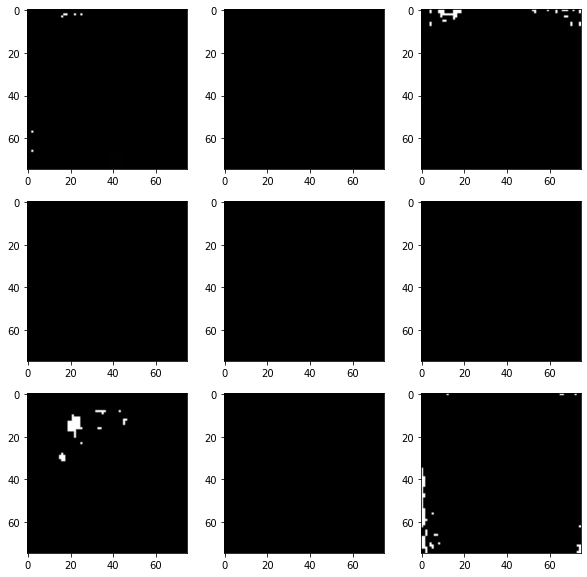

In [99]:
image_batch, image_label = next(iter(train_ds))
image_batch = inceptionv3_preprocess(image_batch)

fig, ax = plt.subplots(3,3,figsize=(10,10))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(image_batch[index],dtype=np.uint8))
plt.show()

### Freeze Model For Transfer Learning

In [100]:
base_model_inceptionv3.trainable = False

In [101]:
base_model_inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, None, None, 3 864         input_20[0][0]                   
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, None, None, 3 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 3 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

### See output shape of base layer

In [102]:
#update base layer
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = tf.keras.layers.experimental.preprocessing.Resizing(height=75,width=75) (inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
outputs = base_model_inceptionv3(x)
model = tf.keras.Model(inputs,outputs)

In [103]:
image_batch, label_batch = next(iter(train_ds))
preds = model(image_batch)

In [104]:
preds.shape

TensorShape([32, 1, 1, 2048])

### Create Transfer Learning Model

In [106]:
#create model
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = tf.keras.layers.experimental.preprocessing.Resizing(height=75,width=75)(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model_inceptionv3(x)
outputs = tf.keras.layers.Dense(units=len(class_names),activation='softmax')(x)
model_inceptionv3 = tf.keras.Model(inputs,outputs)

In [114]:
#complie model
base_learning_rate = 0.0001
model_inceptionv3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])

In [115]:
#view model summary
model_inceptionv3.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
resizing_11 (Resizing)       (None, 75, 75, 3)         0         
_________________________________________________________________
tf.math.truediv_15 (TFOpLamb (None, 75, 75, 3)         0         
_________________________________________________________________
tf.math.subtract_15 (TFOpLam (None, 75, 75, 3)         0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 6)           12294     
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________

In [116]:
#initial loss and accuracy
accuracy0_inceptionv3, loss0_inceptionv3 = model_inceptionv3.evaluate(valid_ds)

296/296 [==============================] - 9s 23ms/step - loss: 2.3774 - accuracy: 0.1719


In [117]:
#dislay resuls
print(f"Initial accuracy of InceptionV3: {accuracy0_inceptionv3}")
print(f"Initial loss of InceptionV3: {loss0_inceptionv3}")

Initial accuracy of InceptionV3: 2.3774256706237793
Initial loss of InceptionV3: 0.17190249264240265


### Train Model

In [119]:
#train model
inital_epochs = 5
history_inceptionv3 = model_inceptionv3.fit(train_ds,
                                            epochs = inital_epochs,
                                            validation_data=valid_ds)

Epoch 1/5
1474/1474 [==============================] - 46s 29ms/step - loss: 0.2883 - accuracy: 0.1911 - val_loss: 0.0867 - val_accuracy: 0.1925
Epoch 2/5
1474/1474 [==============================] - 41s 28ms/step - loss: 0.0634 - accuracy: 0.1924 - val_loss: 0.0456 - val_accuracy: 0.1919
Epoch 3/5
1474/1474 [==============================] - 42s 28ms/step - loss: 0.0373 - accuracy: 0.1933 - val_loss: 0.0304 - val_accuracy: 0.1928
Epoch 4/5
1474/1474 [==============================] - 41s 28ms/step - loss: 0.0258 - accuracy: 0.1934 - val_loss: 0.0234 - val_accuracy: 0.1916
Epoch 5/5
1474/1474 [==============================] - 41s 28ms/step - loss: 0.0195 - accuracy: 0.1938 - val_loss: 0.0189 - val_accuracy: 0.1924


### Plot Learning Curves

In [120]:
#get training accuracy and loss from history
train_acc = history_inceptionv3.history['accuracy']
train_loss = history_inceptionv3.history['loss']

#get validation accuracy and loss from history
valid_acc = history_inceptionv3.history['val_accuracy']
valid_loss = history_inceptionv3.history['val_loss']

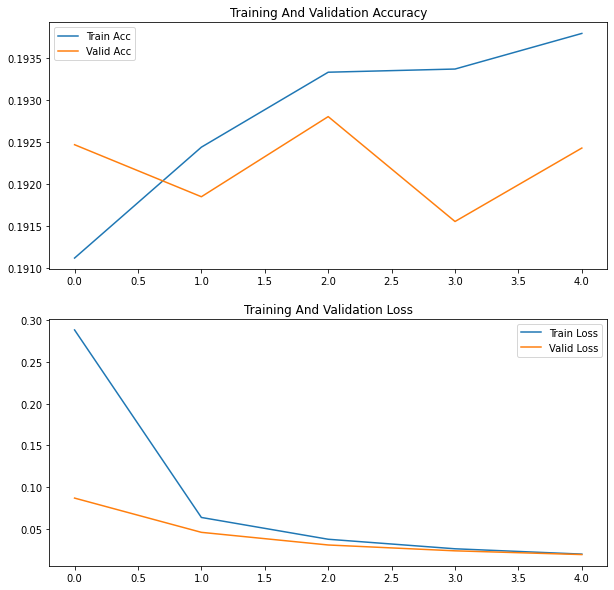

In [121]:
#plot
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(train_acc,label="Train Acc")
ax[0].plot(valid_acc,label="Valid Acc")
ax[0].title.set_text("Training And Validation Accuracy")
ax[0].legend(loc='best')

ax[1].plot(train_loss,label="Train Loss")
ax[1].plot(valid_loss,label="Valid Loss")
ax[1].title.set_text("Training And Validation Loss")
ax[1].legend(loc='best')

plt.show()

### Evaluate on Test Set

In [125]:
#visualize some results
image_batch, label_batch = next(iter(test_ds))
predictions = model_inceptionv3.predict(image_batch)
predictions = np.argmax(predictions,axis=1)

array([[[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0]]])

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(image_batch[index],dtype=np.uint8))
  #a.title.set_text(f"Actual:{class_names[label_batch[index]]} \n Predicted:{class_names[predictions[index]]}")
  if predictions[index] == label_batch[index]:
    a.title.set_color("green")
  else:
    a.title.set_color("red")

plt.show()

# See output of resizing layer, redo inception Net

## Resent50-V2

### Download Base Model

In [59]:
base_model_resenet50_v2 = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                                  weights="imagenet",
                                                                  input_shape=None)

94674944/94668760 [==============================] - 1s 0us/step


### Get Model's Preprocessing Function

In [ ]:
resetnet50_v2_preprocessing = tf.keras.applications.resnet_v2.preprocess_input

### Visualize Outputs of Model's Preprocessing Function

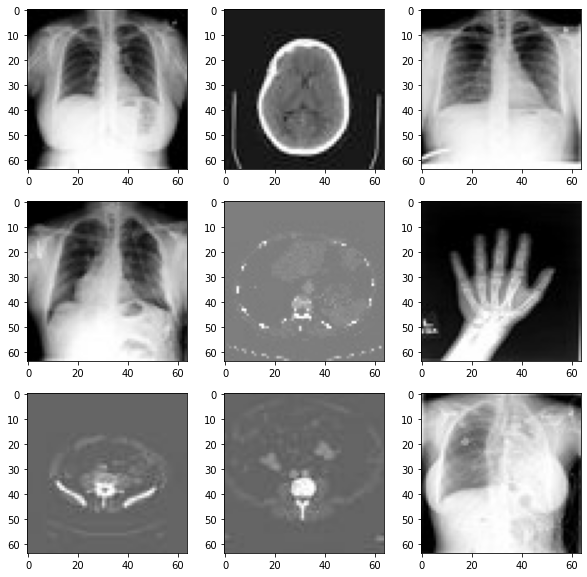

In [ ]:
image_batch, label_batch = next(iter(train_ds))
preprocessed_image_batch = resetnet50_v2_preprocessing(image_batch)

fig, ax  = plt.subplots(3,3,figsize=(10,10))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(image_batch[index],dtype=np.uint8))
plt.show()

### Freeze Model For Transfer Learning

In [ ]:
base_model_resenet50_v2.trainable = False

In [ ]:
base_model_resenet50_v2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### See output shape of base layer

In [ ]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = resetnet50_v2_preprocessing(inputs)
ouputs = base_model_resenet50_v2(x)
model = tf.keras.Model(inputs,ouputs)

In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 2, 2, 2048])

### Create Transfer Learning Model

In [ ]:
#create model using functional api

inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = resetnet50_v2_preprocessing(inputs)
x = base_model_resenet50_v2(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(units = len(class_names),activation='softmax')(x)
model_resnet50v2 = tf.keras.Model(inputs,outputs)

In [ ]:
#compile model
base_learning_rate = 0.0001
model_resnet50v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                         metrics=['accuracy'])

In [ ]:
#view model summary

model_resnet50v2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 64, 64, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
__________________________________________

In [ ]:
#initial loss and accuracy
accuracy0_resnet50v2, loss0_resnet50v2 = model_resnet50v2.evaluate(valid_ds)

296/296 [==============================] - 11s 29ms/step - loss: 3.3034 - accuracy: 0.2311


In [ ]:
#display the results
print(f"Initial Accuracy of Resent50v2: {accuracy0_resnet50v2}")
print(f"Initial Loss of Resent50v2: {loss0_resnet50v2}")

Initial Accuracy of Resent50v2: 3.3034377098083496
Initial Loss of Resent50v2: 0.2311190962791443


### Train Model

In [ ]:
initial_epochs = 5
history_resnet50v2 = model_resnet50v2.fit(train_ds,
                                         epochs=initial_epochs,
                                         validation_data = valid_ds)

Epoch 1/5
1474/1474 [==============================] - 52s 33ms/step - loss: 0.1892 - accuracy: 0.9463 - val_loss: 0.0269 - val_accuracy: 0.9956
Epoch 2/5
1474/1474 [==============================] - 48s 33ms/step - loss: 0.0177 - accuracy: 0.9971 - val_loss: 0.0118 - val_accuracy: 0.9982
Epoch 3/5
1474/1474 [==============================] - 49s 33ms/step - loss: 0.0084 - accuracy: 0.9989 - val_loss: 0.0071 - val_accuracy: 0.9988
Epoch 4/5
1474/1474 [==============================] - 49s 33ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0047 - val_accuracy: 0.9993
Epoch 5/5
1474/1474 [==============================] - 49s 33ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0034 - val_accuracy: 0.9993


### Plot Learning Curves

In [ ]:
#get training accuracy and loss from history
train_acc = history_resnet50v2.history['accuracy']
train_loss = history_resnet50v2.history['loss']

#get validation accuracy and loss from history
valid_acc = history_resnet50v2.history['val_accuracy']
valid_loss = history_resnet50v2.history['val_loss']

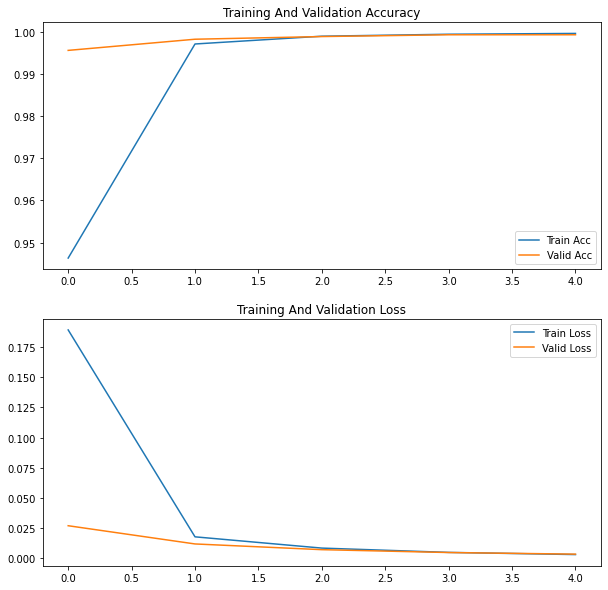

In [ ]:
#plot
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(train_acc,label="Train Acc")
ax[0].plot(valid_acc,label="Valid Acc")
ax[0].title.set_text("Training And Validation Accuracy")
ax[0].legend(loc='best')

ax[1].plot(train_loss,label="Train Loss")
ax[1].plot(valid_loss,label="Valid Loss")
ax[1].title.set_text("Training And Validation Loss")
ax[1].legend(loc='best')

plt.show()

### Evaluate on Test Set

In [ ]:
#evaluate test set
acc_resnet50v2, loss_resnet50v2 = model_resnet50v2.evaluate(test_ds)

73/73 [==============================] - 2s 29ms/step - loss: 0.0022 - accuracy: 0.9996


In [ ]:
#display results
print(f"Accuracy of Resnet50v2 on Test Set: {acc_resnet50v2}")
print(f"Loss of Resnet50v2 on Test Set: {loss_resnet50v2}")

Accuracy of Resnet50v2 on Test Set: 0.0022330640349537134
Loss of Resnet50v2 on Test Set: 0.9995719194412231


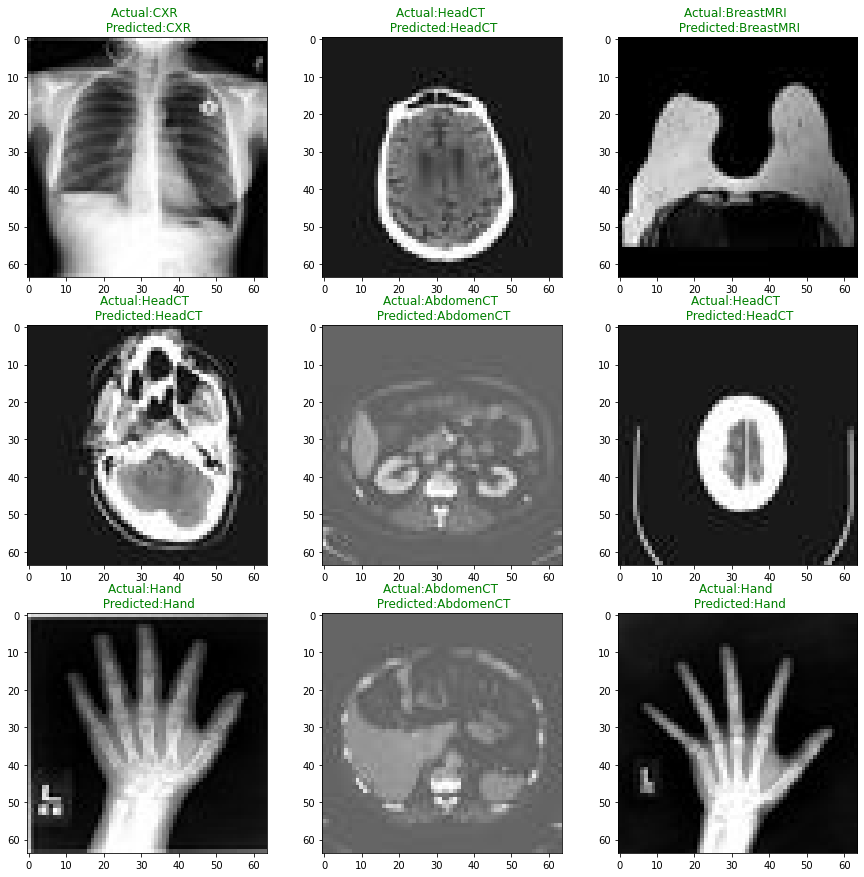

In [ ]:
#visualize some results
image_batch, label_batch = next(iter(test_ds))
predictions = model_resnet50v2.predict(image_batch)
predictions = np.argmax(predictions,axis=1)

fig, ax = plt.subplots(3,3,figsize=(15,15))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(image_batch[index],dtype=np.uint8))
  a.title.set_text(f"Actual:{class_names[label_batch[index]]} \n Predicted:{class_names[predictions[index]]}")
  if predictions[index] == label_batch[index]:
    a.title.set_color("green")
  else:
    a.title.set_color("red")

plt.show()

## Inception Resnets V2

### Download Base Model

In [ ]:
base_model_inception_resnet50v2 = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                                          weights="imagenet",
                                                                          input_shape=None)

219062272/219055592 [==============================] - 3s 0us/step


### Get Model's Preprocessing Function

In [ ]:
inception_resnet50v2_preprocessing = tf.keras.applications.inception_resnet_v2.preprocess_input

### Visualize Outputs of Model's Preprocessing Function

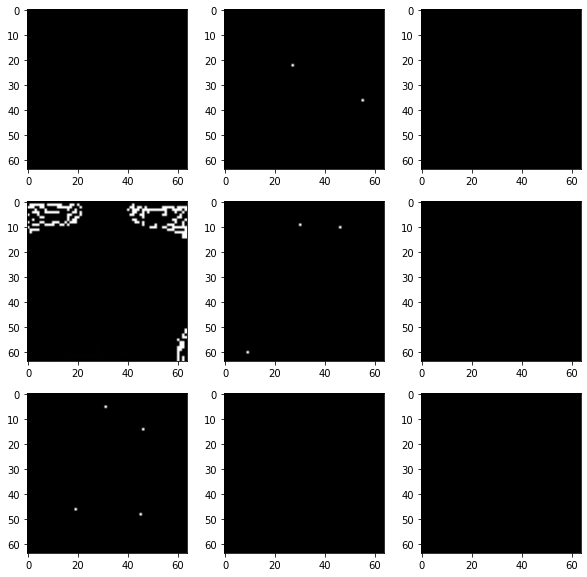

In [ ]:
image_batch, label_batch = next(iter(train_ds))
preprocessed_image_batch = inception_resnet50v2_preprocessing(image_batch)

fig, ax = plt.subplots(3,3,figsize=(10,10))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(preprocessed_image_batch[index],dtype=np.uint8))

plt.show()

### Freeze Model For Trasnfer Learning

In [ ]:
base_model_inception_resnet50v2.trainable = False

In [ ]:
base_model_inception_resnet50v2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
________________________________________________________________________________

### See output shape of base layer

In [ ]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = inception_resnet50v2_preprocessing(inputs)
outputs = base_model_inception_resnet50v2(x)
model = tf.keras.Model(inputs,outputs)

NameError: ignored